# Image Classification

### Classify Whether the Image is cat,Dog,Horse,Human

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image

Using TensorFlow backend.


### Data Preparation

In [6]:
import os
from pathlib import Path

In [38]:
p=Path('./images/')

dirs=p.glob("*")
image_data=[]
labels=[]
labels_dict={'cat':0,"dog":1,'horse':2,"human":3}
for folder_dir in dirs:
    
    label=str(folder_dir).split('\\')[-1][:-1] # cats->cat
    
    for img_path in folder_dir.glob('*.jpg'):
        img=image.load_img(img_path,target_size=(32,32))
        img_array=image.img_to_array(img)
        image_data.append(img_array)
        labels.append(labels_dict[label])

In [39]:
print(len(image_data))
print(len(labels))

808
808


In [73]:
# Converting into numpy array
image_data=np.array(image_data,dtype='float32')/255.0
labels=np.array(labels)
print(image_data.shape,labels.shape)

(808, 3072) (808,)


In [74]:
# Shuffling the data
import random

combined=list(zip(image_data,labels))
random.shuffle(combined)

image_data[:],labels[:]=zip(*combined)

### visualization 

In [55]:
def drawImage(img):
    plt.imshow(img)
    plt.show()
    return

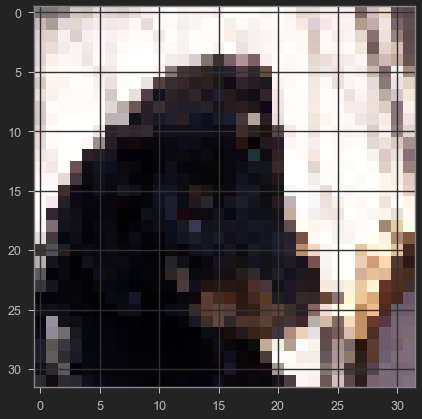

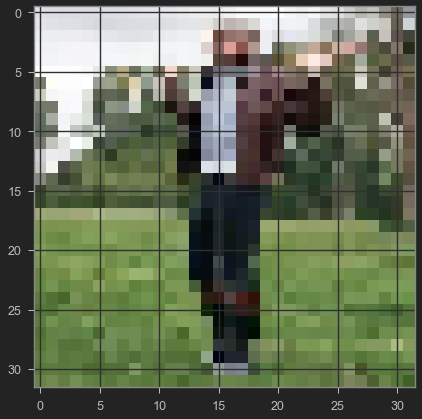

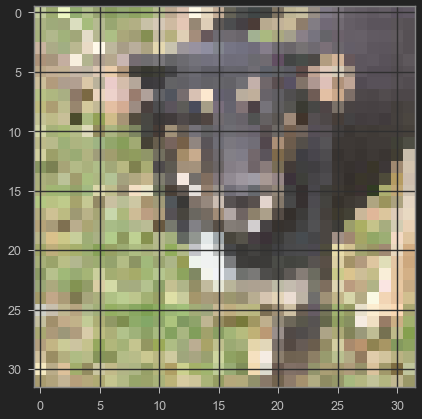

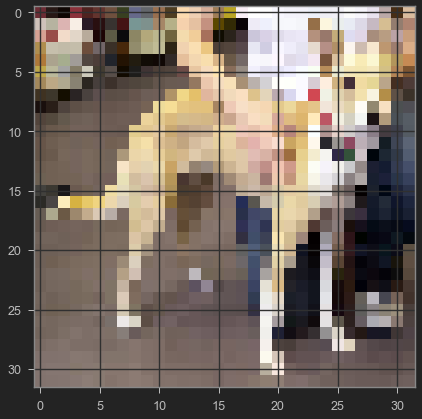

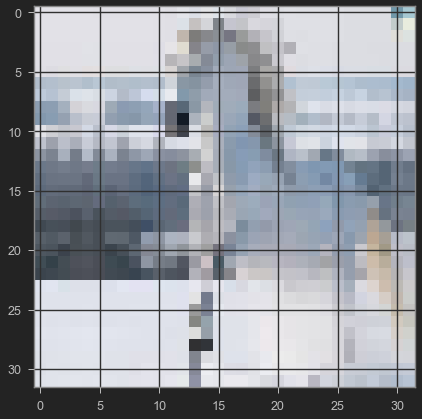

In [56]:
for i in range(5):
    drawImage(image_data[i])

In [57]:
## This blurriness due to pixalation of images we have converted into shape of 32 * 32

In [134]:
class SVM:
    
    def __init__(self,c=1.0):
        
        self.c=c
        self.w=0
        self.b=0
        
    def loss(self,w,b,X,Y):
        
        loss_=0.0
        
        loss_+=.5*np.dot(w,w.T)
        
        m=X.shape[0]
        
        for i in range(m):
            ti=Y[i]*(np.dot(w,X[i].T)+b)
            loss_+=self.c*max(0,1-ti)
            
        return loss_[0][0]
    
    def fit(self,X,Y,fold_size=100,learning_rate=0.00001,max_iteration=1000):
        no_of_features=X.shape[1]
        no_of_samples=X.shape[0]
        
        n=learning_rate
        c=self.c
        
        w=np.zeros((1,no_of_features))
        b=0
        
        losses=[]
        
        for i in range(max_iteration):
            
            l=self.loss(w,b,X,Y)
            losses.append(l)
            
            ids=np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            for batch_start in range(0,no_of_samples,fold_size):
                
                grad_w=0
                grad_b=0
                
                for j in range(batch_start,batch_start+fold_size):
                        if j<no_of_samples:
                            i=ids[j]
                            ti=Y[i]*(np.dot(w,X[i].T)+b)

                            if ti>1:
                                grad_w+=0
                                grad_b+=0
                            else:
                                grad_w+=c*Y[i]*X[i]
                                grad_b+=c*Y[i]
                                
                w = w - n*w + n*grad_w
                b = b + n*grad_b
                
        self.w=w
        self.b=b
        return w,b,losses        

In [135]:
M=image_data.shape[0]
image_data=image_data.reshape((M,-1))
print(image_data.shape)
print(labels.shape)

(808, 3072)
(808,)


In [136]:
no_class=len(np.unique(labels))
print(no_class)

4


In [137]:
def classWiseData(x,y):
    data={}
    for i in range(no_class):
        data[i]=[]
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    for k in data.keys():
        data[k]=np.array(data[k])
    return data

In [138]:
data=classWiseData(image_data,labels)

In [139]:
print(data[0].shape) # cat
print(data[1].shape) # dog
print(data[2].shape) # horse
print(data[3].shape) # human

(202, 3072)
(202, 3072)
(202, 3072)
(202, 3072)


In [140]:
def getDataPair(d1,d2):
    
    l1,l2=d1.shape[0],d2.shape[0]
    
    sample=l1+l2
    feature=d1.shape[1]
    
    data_pair=np.zeros((sample,feature))
    data_label=np.zeros((sample,))
    
    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2
    
    data_label[:l1]=-1
    data_label[l1:]=+1
    
    return data_pair,data_label



In [141]:
mysvm=SVM()

In [142]:
def trainSVM(x,y):
    
    svm_classifiers={}
    
    for i in range(no_class):
        
        svm_classifiers[i]={}
        
        for j in range(i+1,no_class):
            
            xpair,ypair=getDataPair(data[i],data[j])
            wts,b,loss=mysvm.fit(xpair,ypair)
            svm_classifiers[i][j]=(wts,b)
            
    return svm_classifiers
    

In [143]:
svm_classifier=trainSVM(image_data,labels)

In [128]:
cats_dogs=svm_classifier[0][1] # cats and dogs
print(cats_dogs[0].shape)  
print(cats_dogs[1])

(1, 3072)
7.453889935837843e-20


In [129]:
def binaryPredict(X,w,b):
    z=np.dot(X,w.T)+b
    
    if(z>=0):
        return 1
    else:
        return 0

In [130]:
def predict(X):
    
    count=np.zeros((no_class,))
    
    for i in range(no_class):
        
        for j in range(i+1,no_class):
            w,b=svm_classifier[i][j]
            
            z=binaryPredict(X,w,b)
            
            if(z==1):
                count[j]+=1
            else:
                count[i]+=1
    final_prediction=np.argmax(count)
    return final_prediction

In [131]:
print(predict(image_data[16])) #predict
print(labels[16]) # actual

3
3


In [132]:
def accuracy(X,Y):
    
    count=0
    
    for i in range(X.shape[0]):
        prediction=predict(X[i])
        if(prediction==Y[i]):
            count+=1
            
    return count/X.shape[0]

In [133]:
accuracy(image_data,labels)

0.25